In [19]:
# import libraries
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import os
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose, Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [20]:
# config
noise_dimension = 100  
batch_size = 64 
width, height, channels = 128, 128, 1

In [21]:
main_dir = "./data/brain_tumor_dataset/yes"

In [22]:
# loading the dataset
images = []
for i in os.listdir(main_dir):
    img = os.path.join(main_dir,i)
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128,128))
    images.append(img)      
dataset = np.array(images)

In [23]:
print(dataset.shape)
X_train = dataset
# normalize => scale from [0,255] to [-1,1] => Generator uses tanh activation so rescale original images to -1 to 1 to match the output of generator.
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
# reshape
X_train = X_train.reshape(-1, width, height, channels)

(155, 128, 128)


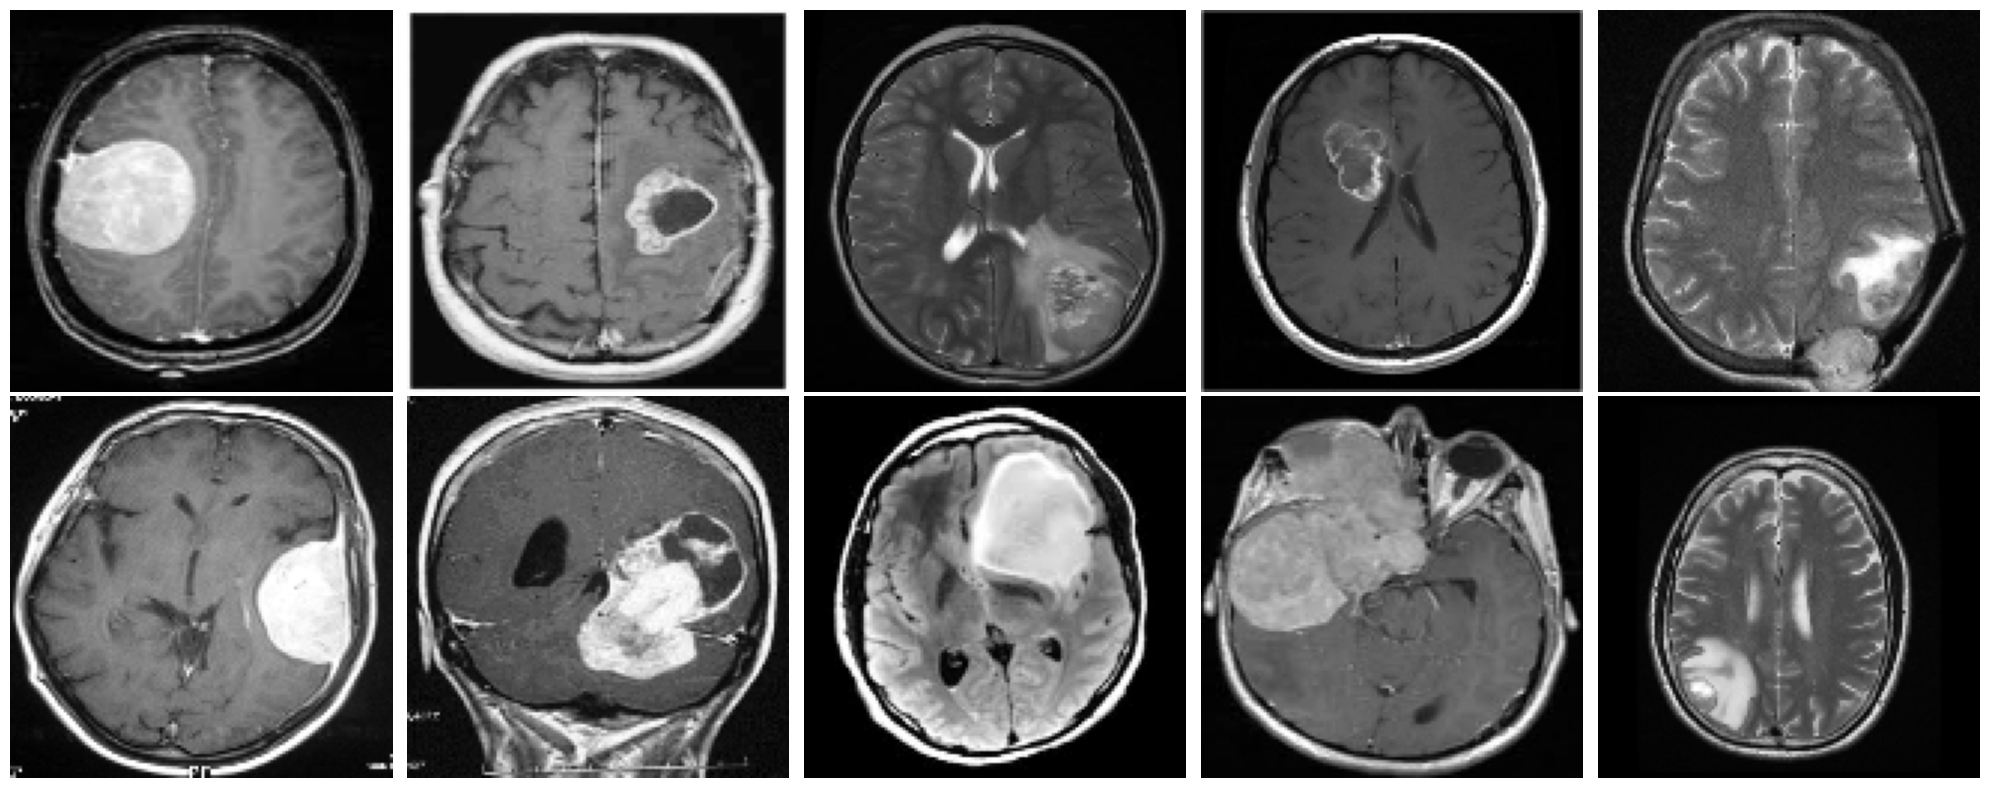

In [24]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [25]:
# a batch of random real samples to train the GAN on a half batch of real images and another half batch of fake images
# For real images (label 1) and for fake (label 0)
def real_samples(dataset, n_samples):
	# choose random images
	indx = np.random.randint(0, dataset.shape[0], n_samples) # dataset.shape = 155
	X = dataset[indx]
	# generate class labels
	y = np.ones((n_samples, 1)) # label 1 to fool discriminator that they are real
	return X, y

In [ ]:
# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	x_input = np.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [26]:
# Input: random noise (Latent Vector) => 1D array of size 100 
# Output: produces image(here: 128x128)
def generator(noise_dimension):
    n_nodes = 256*32*32
    model = Sequential([
        # the first layes is a 1-D vector so it's a dense layer (not a 2-D convolutional layer)
        # reshape input latent vector into 32x32 as a starting point 
        # there are 256*32*32 nodes in the Dense layes and they should be upscaled to 128x128x1 image for output
        Dense(n_nodes, input_dim=noise_dimension), 
        LeakyReLU(alpha=0.2),
        Reshape((32, 32, 256)),

        # upsample to 64x64
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        # upsample to 128x128
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        # generate 128*128*1 + the generated images have the value between -1 and 1 (tanh)
        Conv2D(1, (4, 4), padding='same', activation='tanh')]) 
    
        # model is nit compiled as it's not directly trained like the discriminator, generator is trained via GAN combination model
    return model

G_model = generator(noise_dimension)
G_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 262144)            26476544  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 262144)            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 128)    262272    
 ranspose)                                              

In [27]:
# Discriminator is responsible for classifying the generated images as fake or real
# Binary classification (1 or 0) => sigmoid
# Input: fake / Real Image
# Output: the probability of the image being real
def discriminator():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same',input_shape=(width, height, channels)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(width, height, channels))])
    
    model.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return model

D_model = discriminator()
D_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)      

In [ ]:
# the combined generator and discriminator model, for training and updating the generator
# Discriminator is trained separately (remain constant) 
def gan(generator, discriminator):
	discriminator.trainable = False 
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model
